In [1]:
%load_ext Cython
%time
%cython

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


UsageError: Line magic function `%cython` not found (But cell magic `%%cython` exists, did you mean that instead?).


In [2]:
#import needed packages
from gensim.models import doc2vec

import re
import pandas as pd
import numpy as np
import copy

# nltk processing
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier

### Data Exploration
Shown below are the first 10 rows of the master dataset with all fields.

In [3]:
dataMaster = pd.read_csv("dataRecipeMaster.csv") 
dataMaster.head(5)

,title,url,category,prep,cook,total,servings,rating,review_cnt,categories,...,ingred,instruct,fat,calories,carb,protein,chol,sodium,page,reviews_text
0,'Anything Goes' Easy Black Beans,https://www.allrecipes.com/recipe/237247/anyth...,Beans and Peas,PT15M,PT25M,PT40M,8,3.50,6,"['Side Dish', 'Beans and Peas']",...,"['2 (15 ounce) cans black beans, rinsed and dr...","['Stir black beans, 1 cup chicken broth, tomat...",2.3,149 calories;,26.0,8.0,< 1,701,76,"['Darin and I liked it...boys thought so so', ..."
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),https://www.allrecipes.com/recipe/203592/calab...,Tomatoes,PT10M,PT15M,PT30M,8,4.60,83,"['Side Dish', 'Vegetables', 'Tomatoes']",...,"['1 tablespoon vegetable oil', '1/2 small whit...",['Heat the vegetable oil in a saucepan over me...,6.6,97 calories;,5.8,4.8,15,202,15,['A simple and tasty dish! I also used olive o...
2,'Chinese Buffet' Green Beans,https://www.allrecipes.com/recipe/158854/chine...,Green Beans,PT15M,PT10M,PT25M,6,4.54,227,"['Side Dish', 'Vegetables', 'Green Beans']",...,"['1 tablespoon oil, peanut or sesame', '2 clov...",['Heat peanut oil in a wok or large skillet ov...,2.3,55 calories;,8.1,1.6,0,141,5,['**IMPORTANT NOTE** Thanks to everyone who ha...
3,'Got Some Crust' Macaroni and Cheese,https://www.allrecipes.com/recipe/60700/got-so...,Pasta by Shape,PT20M,PT55M,PT1H15M,12,4.22,43,"['Pasta and Noodles', 'Pasta by Shape']",...,"['2 cups elbow macaroni', '1/4 cup butter, div...",['Preheat an oven to 350 degrees F (175 degree...,15.5,286 calories;,23.2,13.1,45,532,1,"[""I made a recipe and a half of this. Instead ..."
4,'Meat's Too Expensive!' Vegetarian Burgers,https://www.allrecipes.com/recipe/237216/meats...,Everyday Cooking,PT15M,PT35M,PT50M,8,4.25,3,['Everyday Cooking'],...,"['water to cover', '1 cup dried lentils', '1/2...",['Pour enough water into a pot that will cover...,9.0,195 calories;,19.8,9.7,26,35,83,"['Best tasting veggie burger I have made, ever..."


The master dataset was trimmed down to use the fields: title, category, categories, ingredients, rating and review_cnt. 

In [4]:
data = dataMaster[['title','category','categories','ingred','rating','review_cnt','reviews_text']].copy()
data.head(5)

,title,category,categories,ingred,rating,review_cnt,reviews_text
0,'Anything Goes' Easy Black Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","['2 (15 ounce) cans black beans, rinsed and dr...",3.50,6,"['Darin and I liked it...boys thought so so', ..."
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),Tomatoes,"['Side Dish', 'Vegetables', 'Tomatoes']","['1 tablespoon vegetable oil', '1/2 small whit...",4.60,83,['A simple and tasty dish! I also used olive o...
2,'Chinese Buffet' Green Beans,Green Beans,"['Side Dish', 'Vegetables', 'Green Beans']","['1 tablespoon oil, peanut or sesame', '2 clov...",4.54,227,['**IMPORTANT NOTE** Thanks to everyone who ha...
3,'Got Some Crust' Macaroni and Cheese,Pasta by Shape,"['Pasta and Noodles', 'Pasta by Shape']","['2 cups elbow macaroni', '1/4 cup butter, div...",4.22,43,"[""I made a recipe and a half of this. Instead ..."
4,'Meat's Too Expensive!' Vegetarian Burgers,Everyday Cooking,['Everyday Cooking'],"['water to cover', '1 cup dried lentils', '1/2...",4.25,3,"['Best tasting veggie burger I have made, ever..."


### Data Cleaning

When looking at the data, it became clear that the most relevant words are the names of food items and categories.  Other words, characters and numbers would not be useful for this exercise. for example, we need to get rid of stop words (common words like "as", "the") and measurement words (for example 1/2 tablespoon) which don't say anything about the food. <br>
For example, "ground beef" becomes "groundbeef", "beef bouillon cube" becomes "beefbouilloncube".

The first step was to define a food vocabulary. Non-food words, such as measurements, punctuation, and descriptions about the state of a food item should be removed from the ingredients. Shown here is a function to remove non-food words from the ingredient words: "clean_data_ingred()".

In [5]:
### removed measurements, descriptive words and anything that's not an ingredient
def clean_data_ingred(ds):
    arr = ['tablespoons','tablespoon','teaspoons','teaspoon','cups','cup','ounces','ounce',
           'pounds','pound','pinches','pinch','tastes','taste','dashes','dash','/',' or ',
           ' as ',' and ', '-','[',']','(',')','.','slices','sliced','slice', '0','1','2','3',
           '4','5','6','7','8','9','juiced','diced','minced','chopped',' cans',' canned ',
           ' can ', ' inches ', ' inch ','package', 'finely', 'crushed', 'shredded', 
           'divided', ' melted ', ' jar ','thawed', ' cut ', ' to ', ' thick ', ' across ', 
           ' bones ', 'optional', ' split ', ' torn ', ' into ', ' strips ', 'peeled',
           ' pieces', ' lightly ', ' beaten ','ground black', 'scrubbed', 'jars', 'beaten',
           'pitted','halved', 'thinly','as needed','large','medium','small','roughly',
           'fluid','drained','crumbled','rinsed','cubed','seeded','fresh',' plus ', ' more ', 
           'deboned', 'prepared', 'cubes', 'uncooked', 'cooked', 'grated', ' lean ',
           'into chunks', 'coarsely','seeded','freshly',' freshly', 'fresh', ' with ', 
           'liquid','quartered','lengthwise','small',' into ',' bite ', ' sized ', ' ly ', 
           ' ed ', ' s ','cut into', ' up ', 'trimmed','frozen','chunks','segments',
           'softened',' cut ', ' stewed','pieces','broken',' cored',' rings',' torn ',
           'seasoned',' into ','eighths','quarters','halves','thirds',' thick ', 'chilled', 
           ' more',' ',"'"]

    ### merge terms that have multiple words, for example 'ground beef' becomes 'groundbeef'
    for item in arr:
        ds = ds.str.replace(item,'')
    ds = ds.str.replace(',,',',')
    return ds

In [6]:
### Remove measurements and anything else that is not a food ingredient from the ingredients data
data['ingred'] = clean_data_ingred(data['ingred'])
data['ingred'].head(10)


0    blackbeans,chickenbroth,more,tomatopaste,groun...
1    vegetableoil,whiteonion,clovesgarlic,zucchini,...
2    oil,peanutsesame,clovesgarlic,greenbeans,white...
3    elbowmacaroni,butter,onion,allpurposeflour,mil...
4    watercover,driedlentils,wheatgerm,onion,greenb...
5    greenbeans,limabeans,redbeans,redbellpepperstr...
6    water,applecidervinegar,seafoodseasoningsuchOl...
7    tomatosauce,water,envelopetacoseasoningmix,chi...
8    strawberries,soymilk,blueberries,scoopsacaipow...
9    headcauliflower,halfandhalf,pepper,garlicpowde...
Name: ingred, dtype: object

## Analysis

The next step was to compute TF-IDF scores for the remaining words. Ingredient terms can consist of more than one word. In order to make sure that the model does not treat an ingredient like "ground beef" as two separate words, for example "ground" and "beef", ingredients with multiple words were combined into a single word. For example, "ground beef" becomes "groundbeef" and "beef bouillon cube" becomes "beefbouilloncube". Each term was then separated by a space.

In [7]:
### separate each term with a space
def create_soup(ds):
    ds = ds.str.replace(',',' ')
    return ds

In [8]:
### Separate each ingredient with a space
data['ingredSpaces'] = create_soup(data['ingred'])
data['ingredSpaces'].head(10)

0    blackbeans chickenbroth more tomatopaste groun...
1    vegetableoil whiteonion clovesgarlic zucchini ...
2    oil peanutsesame clovesgarlic greenbeans white...
3    elbowmacaroni butter onion allpurposeflour mil...
4    watercover driedlentils wheatgerm onion greenb...
5    greenbeans limabeans redbeans redbellpepperstr...
6    water applecidervinegar seafoodseasoningsuchOl...
7    tomatosauce water envelopetacoseasoningmix chi...
8    strawberries soymilk blueberries scoopsacaipow...
9    headcauliflower halfandhalf pepper garlicpowde...
Name: ingredSpaces, dtype: object

### Adding Categories Feature
As we did with the ingredients data, we will remove characters from the Categories data which are not letters, for example, punctuation marks. Multiple word terms will be combined into single words, for example: "side dish" becomes "sidedish".

In [9]:
def clean_categories(ds):
    ds = ds.str.replace(' ','')
    ds = ds.str.lower()
    ds = ds.str.replace('[','')
    ds = ds.str.replace(']','')
    ds = ds.str.replace("''",' ')
    ds = ds.str.replace(',',' ')
    ds = ds.str.replace("'","")
    return ds

In [10]:
data['categories_clean'] = clean_categories(data['categories'])
data['categories_clean'].head()

0             sidedish beansandpeas
1      sidedish vegetables tomatoes
2    sidedish vegetables greenbeans
3      pastaandnoodles pastabyshape
4                   everydaycooking
Name: categories_clean, dtype: object

In [11]:
# Merge ingredients and categories into one column
data['ingred_cat'] = data['ingredSpaces'] + ' ' + data['categories_clean'] 


#### Word Embedding with Gensim Library

### Recipe Classification with Deep Learning

The architecture is therefore comprised of three key pieces:

- Word Embedding: A distributed representation of words where different words that have a similar meaning (based on their usage) also have a similar representation.
- Convolutional Model: A feature extraction model that learns to extract salient features from documents represented using a word embedding.
- Fully Connected Model: The interpretation of extracted features in terms of a predictive output.

The general approach of using CNN for natural language processing is that sentences are mapped to embedding vectors and are available as a matrix input to the model. Convolutions are performed across the input word-wise using differently sized kernels, such as 2 or 3 words at a time. The resulting feature maps are then processed using a max pooling layer to condense or summarize the extracted features.

#### Benchmark
A base configuration can be the one used in the 2011 paper "Natural Language Processing (almost) from Scratch", 2011, by Collobert, et al. The model configurations were discovered via grid search and used across a suite of 7 text classification tasks, summarized as follows:

Transfer function: rectified linear.
Kernel sizes: 2, 4, 5.
Number of filters: 100
Dropout rate: 0.5
Weight regularization (L2): 3
Batch Size: 50
Update Rule: Adadelta



#### CNN Hyperparameters

Use word2vec or GloVe word embeddings as a starting point and tune them while fitting the model.
Grid search across different kernel sizes to find the optimal configuration for your problem, in the range 1-10.
Search the number of filters from 100-600 and explore a dropout of 0.0-0.5 as part of the same search.
Explore using tanh, relu, and linear activation functions.


In [12]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
import tensorflow as tf

Using TensorFlow backend.


### Ingredient Word Cloud 
Shown below is a word cloud which illustrates how frequently some ingredients occur among all the recipes in our dataset.

In [13]:
from wordcloud import WordCloud

#wordcloud = WordCloud().generate(str(data['ingredSpaces']))
wordcloud = WordCloud().generate(str(data['ingred_cat']))


import matplotlib.pyplot as plt

                                 
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



<Figure size 1600x1200 with 1 Axes>

The larger the font size, the more frequently the ingredient occurs in our dataset of recipes. The largest words, such as onion, oliveoil, butter, chickenbroth, clovesgarlic and vegetableoil can even be considered as what chef's call "staples", i.e. ingredients that are so frequently used that it can be assumed that every cook is well stocked with these items in their kitchens. For our purposes, these "high frequency" ingredients are less important because they are so common.

### Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each recipe
Calculating TF-IDF indecates the importance of each food term to the recipe it belongs to. How many times a word appears in the recipe it belongs to is the TF (term frequency). The higher the TF value, the more important the term is. However, if the term appears in all recipes, then it is not really important for a particular recipe to be identified. For example, most recipes contain "salt". If every recipe contains salt then the term "salt" would not be helpful to identify each recipe. So we want to have a weighting system that decreases the importance of a term like salt when the number of the recipes it appears in increases.<br>
TF-IDF is a weighting mechanism that calculates the importance of each term to each recipe by increasing the importance based on the term frequency while decreasing the importance based on the recipe frequency.<br>

In [14]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['ingred_cat'].values.astype('U'))

#Output the shape of tfidf_matrix
tfidf_matrix.shape


(10542, 7876)

In [15]:
print("Now the recipes are characterized by the ingredients with the highest TF-IDF scores.") 
print(tfidf_matrix.shape[1], "different terms were used to describe", tfidf_matrix.shape[0], "recipes in the dataset.")

Now the recipes are characterized by the ingredients with the highest TF-IDF scores.
7876 different terms were used to describe 10542 recipes in the dataset.


In [16]:
tfidf_matrix

<10542x7876 sparse matrix of type '<class 'numpy.float64'>'
	with 132313 stored elements in Compressed Sparse Row format>

#### Calculating Similarity

Using the TFIDF matrix we can compute a similarity score, the cosine distance between the high TF-IDF words as a vector. We will use a cosine similarity to calculate a number that denotes the similarity between two recipes.

$$cosine(x,y0) = x.y^T / ||x||.||y||$$


To compute the cosine distance we think of the sets of high TF-IDF words as a vector, with one component for each possible word. The vector has 1 if the word is in the set and 0 if not. Almost all components are 0 in both, and 0’s do not impact the value of the dot product. The dot product is the size of the intersection of the two sets of ingredient words, and the lengths of the vectors are the square roots of the numbers of words in each set. That lets us compute the cosine of the angle between the vectors as the dot product divided by the product of the vector lengths.


In [17]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Next, we need a function that takes in a recipe title as an input and outputs a list of up to the 10 most similar recipes. To do this, we make a reverse mapping of recipe titles and dataframe indices. This gives us a way to identify the index of a recipe, given its title.

In [18]:
#Construct a reverse map of indices and recipe titles
indices = pd.Series(data.index, index=data['ingred_cat'])
indices.head(5)

ingred_cat
blackbeans chickenbroth more tomatopaste groundcumin oliveoil onion greenbellpepper jalapenopepper clovesgarlic more whitesugar chipotleflavoredhotsauce more sidedish beansandpeas                                                    0
vegetableoil whiteonion clovesgarlic zucchini thick tomatoes salt mildCheddarcheese sidedish vegetables tomatoes                                                                                                                       1
oil peanutsesame clovesgarlic greenbeans whitesugar oystersauce soysauce sidedish vegetables greenbeans                                                                                                                                2
elbowmacaroni butter onion allpurposeflour milk salt whitepepper Worcestershiresauce hotpeppersaucesuchTabasco® yellowmustard Cheddarcheese Parmesancheese Cheddarcheese Parmesancheese drybreadcrumbs pastaandnoodles pastabyshape    3
watercover driedlentils wheatgerm onion greenbellpepper m

#### CountVectorizer instead of TF-IDF

We will also try using the CountVectorizer() instead of TF-IDF for this attempt. Using CountVectorizer will not down-weight the presence of an ingredient if it appears in relatively more recipes. We will use a CountVectorizer with a pairwise cosine similarity calculation and then compare the results of TF-IDF vs CountVectorizer.

In [19]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['ingred_cat'])


In [20]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [21]:
count_matrix

<10542x7876 sparse matrix of type '<class 'numpy.int64'>'
	with 132313 stored elements in Compressed Sparse Row format>

In [22]:
# Function that takes in ingredient as input and outputs most similar ingredients
def get_recommendations(title, cosine_sim=cosine_sim):

    # Get the index of the recipe title that matches the title
    row = data.loc[data['title'] == title].index[0]
    idx = indices[row]
    #print("row = ", row)

    # Get the pairwise similarity scores of all titles with that title
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:16]
 
    # Get the recipe indices
    recipe_indices = [i[0] for i in sim_scores]
    
    # Return the top 10-15 most similar recipes
    return data['title'].iloc[recipe_indices].drop_duplicates()


#### Results
Here are some examples of recipe recommendations. We call the "get_recommendations()" function and pass in the index of the recipe and specify cosine similarity. The function returns a list of up to 10 closest recipes.

In [23]:
data

,title,category,categories,ingred,rating,review_cnt,reviews_text,ingredSpaces,categories_clean,ingred_cat
0,'Anything Goes' Easy Black Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","blackbeans,chickenbroth,more,tomatopaste,groun...",3.50,6,"['Darin and I liked it...boys thought so so', ...",blackbeans chickenbroth more tomatopaste groun...,sidedish beansandpeas,blackbeans chickenbroth more tomatopaste groun...
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),Tomatoes,"['Side Dish', 'Vegetables', 'Tomatoes']","vegetableoil,whiteonion,clovesgarlic,zucchini,...",4.60,83,['A simple and tasty dish! I also used olive o...,vegetableoil whiteonion clovesgarlic zucchini ...,sidedish vegetables tomatoes,vegetableoil whiteonion clovesgarlic zucchini ...
2,'Chinese Buffet' Green Beans,Green Beans,"['Side Dish', 'Vegetables', 'Green Beans']","oil,peanutsesame,clovesgarlic,greenbeans,white...",4.54,227,['**IMPORTANT NOTE** Thanks to everyone who ha...,oil peanutsesame clovesgarlic greenbeans white...,sidedish vegetables greenbeans,oil peanutsesame clovesgarlic greenbeans white...
3,'Got Some Crust' Macaroni and Cheese,Pasta by Shape,"['Pasta and Noodles', 'Pasta by Shape']","elbowmacaroni,butter,onion,allpurposeflour,mil...",4.22,43,"[""I made a recipe and a half of this. Instead ...",elbowmacaroni butter onion allpurposeflour mil...,pastaandnoodles pastabyshape,elbowmacaroni butter onion allpurposeflour mil...
4,'Meat's Too Expensive!' Vegetarian Burgers,Everyday Cooking,['Everyday Cooking'],"watercover,driedlentils,wheatgerm,onion,greenb...",4.25,3,"['Best tasting veggie burger I have made, ever...",watercover driedlentils wheatgerm onion greenb...,everydaycooking,watercover driedlentils wheatgerm onion greenb...
5,"""Couldn't Be Easier"" Three-Bean Salad",Three Bean Salad,"['Salad', 'Beans', 'Three Bean Salad']","greenbeans,limabeans,redbeans,redbellpepperstr...",4.00,3,['I thought this was good and it was even bett...,greenbeans limabeans redbeans redbellpepperstr...,salad beans threebeansalad,greenbeans limabeans redbeans redbellpepperstr...
6,"""Eat Them Right Out of the Pot"" Vegetarian Col...",Greens,"['Side Dish', 'Vegetables', 'Greens']","water,applecidervinegar,seafoodseasoningsuchOl...",4.50,4,"[""I have to admit that I just microwaved froze...",water applecidervinegar seafoodseasoningsuchOl...,sidedish vegetables greens,water applecidervinegar seafoodseasoningsuchOl...
7,"""Pantry Raid"" Chicken Enchilada Casserole",Mexican,"['World Cuisine', 'Latin American', 'Mexican']","tomatosauce,water,envelopetacoseasoningmix,chi...",4.62,294,['Yum. OH! I made this as a one-dish crockpo...,tomatosauce water envelopetacoseasoningmix chi...,worldcuisine latinamerican mexican,tomatosauce water envelopetacoseasoningmix chi...
8,"""The Jackson"" Detox Smoothie",Strawberry,"['Drinks', 'Smoothies', 'Strawberry']","strawberries,soymilk,blueberries,scoopsacaipow...",0.00,0,[],strawberries soymilk blueberries scoopsacaipow...,drinks smoothies strawberry,strawberries soymilk blueberries scoopsacaipow...
9,"""These Aren't Potatoes?"" Garlic Cauliflower Au...",Vegetables,"['Side Dish', 'Vegetables']","headcauliflower,halfandhalf,pepper,garlicpowde...",3.33,3,['What can I say other than it was really good...,headcauliflower halfandhalf pepper garlicpowde...,sidedish vegetables,headcauliflower halfandhalf pepper garlicpowde...


##### Example: Baked Slow Cooker Chicken, TF-IDF

In [25]:
get_recommendations('Baked Slow Cooker Chicken', cosine_sim)  


1153                               Beer Butt Chicken
588                            Bacon Roasted Chicken
8429                    Simple Whole Roasted Chicken
6708                          Oven Fried Chicken III
4997                          Honey Baked Chicken II
8987                          Spicy Lemon Pork Saute
4228                    Get a Husband Brunswick Stew
10147          Vegetarian Alternative to Ground Beef
4965     Homemade Chicken Cacciatore, Sicilian-Style
8490                       Slow Cooked Pork Barbeque
2424                         Chicken Chile Spaghetti
Name: title, dtype: object

##### Example: Baked Slow Cooker Chicken, CountVectorizer

In [26]:
get_recommendations('Baked Slow Cooker Chicken', cosine_sim2) 

1153                         Beer Butt Chicken
588                      Bacon Roasted Chicken
4931       High Temperature Eye-of-Round Roast
8490                 Slow Cooked Pork Barbeque
8017                Sarge's EZ Pulled Pork BBQ
10147    Vegetarian Alternative to Ground Beef
1785                               Bum's Lunch
8504                      Slow Cooker Barbeque
1862                              Cabin Dinner
2451                     Chicken Fried Steak I
4645                   Ground Beef and Cabbage
5402                         Juicy Butt Steaks
Name: title, dtype: object

##### Example: Steamed Asian Sesame Veggies, TF-IDF

In [27]:
get_recommendations('Steamed Asian Sesame Veggies', cosine_sim) 

9147                            Steamed Broccoli
1653         Broccoli in Roast Chicken Drippings
1671           Broccoli With Lemon Almond Butter
9586                              Tangy Broccoli
8774              Snow Peas with Water Chestnuts
7781                      Roasted Broccoli Salad
8225                             Sesame Broccoli
5327    Japanese Spinach with Sweet Sesame Seeds
9175                          Stir-Fried Pumpkin
8773                          Snow Peas Oriental
1658                          Broccoli Polonaise
1642         Broccoli Cheese Casserole with Rice
2501                            Chicken Stir-Fry
9181         Stir-Fry Broccoli With Orange Sauce
8226                Sesame Cabbage and Mushrooms
Name: title, dtype: object

##### Example: Steamed Asian Sesame Veggies, CountVectorizer

In [28]:
get_recommendations('Steamed Asian Sesame Veggies', cosine_sim2) 

1653           Broccoli in Roast Chicken Drippings
9586                                Tangy Broccoli
9147                              Steamed Broccoli
1642           Broccoli Cheese Casserole with Rice
8225                               Sesame Broccoli
4528    Grilled Broccoli--My Kids Beg for Broccoli
1671             Broccoli With Lemon Almond Butter
7781                        Roasted Broccoli Salad
1658                            Broccoli Polonaise
4198                      Garlic-Sauteed Asparagus
9139           Stacey's Fabulous Broccoli Fritters
9181           Stir-Fry Broccoli With Orange Sauce
3639                Easy Lemon and Garlic Broccoli
8951                Spicy Bok Choy in Garlic Sauce
2213        Cheesy Cauliflower and Broccoli Gratin
Name: title, dtype: object

##### Example: Urban Legend Chocolate Chip Cookies, TF-IDF

In [29]:
get_recommendations('Urban Legend Chocolate Chip Cookies', cosine_sim)

3006                                Cowboy Cookies III
6565                  Oatmeal Chocolate  Coconut Chewy
6486                 Never Fail Chocolate Chip Cookies
4232                       Giant Chocolate Chip Cookie
1222                       Best Chocolate Chip Cookies
7935                                          Rugelach
225                      Anna's Chocolate Chip Cookies
3005                        Cowboy Cookie Mix in a Jar
6566                  Oatmeal Chocolate Chip Cookies I
6697                 Outrageous Chocolate Chip Cookies
464          Award Winning Soft Chocolate Chip Cookies
2653                Chocolate Chocolate Chip Cookies I
1499                          Bobbie's Oatmeal Cookies
10023    Ultimate High Altitude Chocolate Chip Cookies
2654               Chocolate Chocolate Chip Cookies II
Name: title, dtype: object

##### Example: Urban Legend Chocolate Chip Cookies, CountVectorizer

In [30]:
get_recommendations('Urban Legend Chocolate Chip Cookies', cosine_sim2) 

3006                                   Cowboy Cookies III
4232                          Giant Chocolate Chip Cookie
6486                    Never Fail Chocolate Chip Cookies
6565                     Oatmeal Chocolate  Coconut Chewy
1222                          Best Chocolate Chip Cookies
225                         Anna's Chocolate Chip Cookies
464             Award Winning Soft Chocolate Chip Cookies
2653                   Chocolate Chocolate Chip Cookies I
1499                             Bobbie's Oatmeal Cookies
48      Absolutely Sinful Chocolate Chocolate Chip Coo...
2362                 Chewy Chocolate Chip Oatmeal Cookies
3848                            Excellent Oatmeal Cookies
6697                    Outrageous Chocolate Chip Cookies
2363                            Chewy Chocolate Cookies I
2654                  Chocolate Chocolate Chip Cookies II
Name: title, dtype: object

##### Example: Easy Lasagna I, TF-IDF

In [31]:
get_recommendations('Easy Lasagna I', cosine_sim)

3633                           Easy Lasagna I
3634                          Easy Lasagna II
3598                 Easy Four Cheese Lasagna
5916                                Manicotti
8604                      Slow Cooker Lasagna
790                 Baked Spaghetti Casserole
5762                          Linda's Lasagna
5596                 Lasagna Alfredo Roll Ups
2179                           Cheese Lasagna
3715    Easy Spinach Lasagna with White Sauce
3636                         Easy Lasagna III
Name: title, dtype: object

##### Example: Easy Lasagna I, CountVectorizer

In [32]:
get_recommendations('Easy Lasagna I', cosine_sim2) #Easy Steak Sandwich

3633               Easy Lasagna I
3634              Easy Lasagna II
3598     Easy Four Cheese Lasagna
5615              Lazy Lasagna II
790     Baked Spaghetti Casserole
6040        Meat Filled Manicotti
8604          Slow Cooker Lasagna
4895     Hearty Vegetable Lasagna
5916                    Manicotti
5264         Italian Veggie Rolls
2179               Cheese Lasagna
Name: title, dtype: object

##### Example: "The Best Post Workout Shake", TF-IDF

In [33]:
get_recommendations('The Best Post Workout Shake', cosine_sim) 

3343     Dairy-Free Chocolate Peanut Banana Smoothie
9368            Superfood Chocolate Pudding Smoothie
6937               Peanut Butter Strawberry Smoothie
871            Banana Chocolate Almond Milk Smoothie
4850              Healthy Cocoa, Banana, PB Smoothie
1198                                 Berry Delicious
35                     A Very Intense Fruit Smoothie
3072                              Cranberry Smoothie
5430             Kale and Berries Breakfast Smoothie
3983                              Flax Seed Smoothie
57                  Acai Rainbow Smoothie Bowl for 2
8471                        Skinny Almond Milk Shake
4493                                  Green Smoothie
10220                        Very Berry Tea Smoothie
889                    Banana Peanut Butter Smoothie
Name: title, dtype: object

##### Example: "The Best Post Workout Shake", CountVectorizer

In [34]:
get_recommendations('The Best Post Workout Shake', cosine_sim2) 

3343     Dairy-Free Chocolate Peanut Banana Smoothie
9368            Superfood Chocolate Pudding Smoothie
871            Banana Chocolate Almond Milk Smoothie
1198                                 Berry Delicious
3983                              Flax Seed Smoothie
4850              Healthy Cocoa, Banana, PB Smoothie
6937               Peanut Butter Strawberry Smoothie
7382                         Pumpkin Banana Smoothie
8471                        Skinny Almond Milk Shake
35                     A Very Intense Fruit Smoothie
883                       Banana Mocha Protein Shake
2644    Chocolate Banana Peanut Butter Protein Shake
3072                              Cranberry Smoothie
4493                                  Green Smoothie
4901                     Heavenly Blueberry Smoothie
Name: title, dtype: object

#### Results:
Both TF-IDF and CountVectorizer produced reasonable recipe recommendations based on the submitted recipe title. Many of the first few recipes returned were the same, but there were variations after about the fourth recipe. Overall, while both produced reasonable results, I found that the TF-IDF matrix returned recipes which were closer to the recipe title submitted. For example, "Steamed Asian Vegetables" results using the TF-IDF matrix returned on the mark recipes like "Stir-Fry Broccoli With Orange Sauce", while the CountVectorizer matrix, we see somewhat off the mark recipes like "Cheesy Cauliflower and Broccoli Gratin".


## 2 - Recommender System Considering Ratings and Number of Reviews

Since ratings can be different based on the number of reviews, for example should a recipe with only 3 ratings, where the average rating is 5.0, be evaluated as having a truly higher rating than a recipe with 500 ratings, where the average rating is about 4.0?<br>

In order to be fair, we are going to use a weighted ratings.<br>

v: number of reviews for the recipe<br>

m: minimum number of votes required to be listed<br>

R: average rating of the recipe<br>

C: mean vote across all recipes<br>

We will use 90th percentile as the cutoff in terms of number of reviews.<br>


In [35]:
# read in fields title, ingredients and categories
dataR = data 

dataR.duplicated()
dataR.drop_duplicates()

,title,category,categories,ingred,rating,review_cnt,reviews_text,ingredSpaces,categories_clean,ingred_cat
0,'Anything Goes' Easy Black Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","blackbeans,chickenbroth,more,tomatopaste,groun...",3.50,6,"['Darin and I liked it...boys thought so so', ...",blackbeans chickenbroth more tomatopaste groun...,sidedish beansandpeas,blackbeans chickenbroth more tomatopaste groun...
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),Tomatoes,"['Side Dish', 'Vegetables', 'Tomatoes']","vegetableoil,whiteonion,clovesgarlic,zucchini,...",4.60,83,['A simple and tasty dish! I also used olive o...,vegetableoil whiteonion clovesgarlic zucchini ...,sidedish vegetables tomatoes,vegetableoil whiteonion clovesgarlic zucchini ...
2,'Chinese Buffet' Green Beans,Green Beans,"['Side Dish', 'Vegetables', 'Green Beans']","oil,peanutsesame,clovesgarlic,greenbeans,white...",4.54,227,['**IMPORTANT NOTE** Thanks to everyone who ha...,oil peanutsesame clovesgarlic greenbeans white...,sidedish vegetables greenbeans,oil peanutsesame clovesgarlic greenbeans white...
3,'Got Some Crust' Macaroni and Cheese,Pasta by Shape,"['Pasta and Noodles', 'Pasta by Shape']","elbowmacaroni,butter,onion,allpurposeflour,mil...",4.22,43,"[""I made a recipe and a half of this. Instead ...",elbowmacaroni butter onion allpurposeflour mil...,pastaandnoodles pastabyshape,elbowmacaroni butter onion allpurposeflour mil...
4,'Meat's Too Expensive!' Vegetarian Burgers,Everyday Cooking,['Everyday Cooking'],"watercover,driedlentils,wheatgerm,onion,greenb...",4.25,3,"['Best tasting veggie burger I have made, ever...",watercover driedlentils wheatgerm onion greenb...,everydaycooking,watercover driedlentils wheatgerm onion greenb...
5,"""Couldn't Be Easier"" Three-Bean Salad",Three Bean Salad,"['Salad', 'Beans', 'Three Bean Salad']","greenbeans,limabeans,redbeans,redbellpepperstr...",4.00,3,['I thought this was good and it was even bett...,greenbeans limabeans redbeans redbellpepperstr...,salad beans threebeansalad,greenbeans limabeans redbeans redbellpepperstr...
6,"""Eat Them Right Out of the Pot"" Vegetarian Col...",Greens,"['Side Dish', 'Vegetables', 'Greens']","water,applecidervinegar,seafoodseasoningsuchOl...",4.50,4,"[""I have to admit that I just microwaved froze...",water applecidervinegar seafoodseasoningsuchOl...,sidedish vegetables greens,water applecidervinegar seafoodseasoningsuchOl...
7,"""Pantry Raid"" Chicken Enchilada Casserole",Mexican,"['World Cuisine', 'Latin American', 'Mexican']","tomatosauce,water,envelopetacoseasoningmix,chi...",4.62,294,['Yum. OH! I made this as a one-dish crockpo...,tomatosauce water envelopetacoseasoningmix chi...,worldcuisine latinamerican mexican,tomatosauce water envelopetacoseasoningmix chi...
8,"""The Jackson"" Detox Smoothie",Strawberry,"['Drinks', 'Smoothies', 'Strawberry']","strawberries,soymilk,blueberries,scoopsacaipow...",0.00,0,[],strawberries soymilk blueberries scoopsacaipow...,drinks smoothies strawberry,strawberries soymilk blueberries scoopsacaipow...
9,"""These Aren't Potatoes?"" Garlic Cauliflower Au...",Vegetables,"['Side Dish', 'Vegetables']","headcauliflower,halfandhalf,pepper,garlicpowde...",3.33,3,['What can I say other than it was really good...,headcauliflower halfandhalf pepper garlicpowde...,sidedish vegetables,headcauliflower halfandhalf pepper garlicpowde...


In [36]:
C = dataR['rating'].mean()
print("average rating of all recipes: ",C)

average rating of all recipes:  4.166075697211155


In [37]:
m = dataR['review_cnt'].quantile(0.9)
print("90th percentile for number of reviews, i.e. the top 10th percentile recipes that have been reviews the most: ",m)

90th percentile for number of reviews, i.e. the top 10th percentile recipes that have been reviews the most:  474.0


In [38]:
# Filter out all qualified recipes into a new DataFrame
q_data = dataR.copy().loc[dataR['review_cnt'] >= m]
q_data.shape

(1058, 10)

In [39]:
q_data.duplicated()
q_data.drop_duplicates()

,title,category,categories,ingred,rating,review_cnt,reviews_text,ingredSpaces,categories_clean,ingred_cat
31,A Good Easy Garlic Chicken,Pan-Fried,"['Meat and Poultry', 'Chicken', 'Chicken Breas...","butter,skinless,bonelesschickenbreast,garlicpo...",4.34,1116,"[""Highly recommened for the busy mom/dad! Wha...",butter skinless bonelesschickenbreast garlicpo...,meatandpoultry chicken chickenbreasts pan-fried,butter skinless bonelesschickenbreast garlicpo...
49,Absolutely the Best Chocolate Chip Cookies,Drop Cookies,"['Desserts', 'Cookies', 'Drop Cookies']","butterflavoredshortening,whitesugar,brownsugar...",4.51,1087,"[""Great cookie. I'm very strict about using o...",butterflavoredshortening whitesugar brownsugar...,desserts cookies dropcookies,butterflavoredshortening whitesugar brownsugar...
51,Absolutely Ultimate Potato Soup,Potato Soup,"['Soups, Stews and Chili', 'Soup', 'Vegetable ...","bacon,stalkscelery,onion,clovesgarlic,potatoes...",4.65,1763,"[""This has to be one of the best tasting potat...",bacon stalkscelery onion clovesgarlic potatoes...,soups stewsandchili soup vegetablesoup potatosoup,bacon stalkscelery onion clovesgarlic potatoes...
52,Absolutely Ultimate Potato Soup,Potato Soup,"['Soups, Stews and Chili', 'Soup', 'Vegetable ...","bacon,stalkscelery,onion,clovesgarlic,potatoes...",4.65,1764,"[""This has to be one of the best tasting potat...",bacon stalkscelery onion clovesgarlic potatoes...,soups stewsandchili soup vegetablesoup potatosoup,bacon stalkscelery onion clovesgarlic potatoes...
62,Acorn Squash,Acorn Squash Side Dishes,"['Side Dish', 'Vegetables', 'Squash', 'Acorn S...","acornsquash,butter,brownsugar",4.49,561,"[""This is the only way I've ever had squash bu...",acornsquash butter brownsugar,sidedish vegetables squash acornsquashsidedishes,acornsquash butter brownsugar sidedish vegetab...
64,Actually Delicious Turkey Burgers,Ground,"['Meat and Poultry', 'Turkey', 'Ground']","groundturkey,breadcrumbs,onion,eggwhites,parsl...",4.57,1658,"['Delicious, but needed enhancements. I added ...",groundturkey breadcrumbs onion eggwhites parsl...,meatandpoultry turkey ground,groundturkey breadcrumbs onion eggwhites parsl...
68,Addictive Sweet Potato Burritos,Mexican,"['World Cuisine', 'Latin American', 'Mexican']","vegetableoil,onion,clovesgarlic,kidneybeans,wa...",4.26,1830,['I debated trying these for a long time befor...,vegetableoil onion clovesgarlic kidneybeans wa...,worldcuisine latinamerican mexican,vegetableoil onion clovesgarlic kidneybeans wa...
77,Aimee's Quick Chicken,Chicken Breasts,"['Meat and Poultry', 'Chicken', 'Chicken Breas...","skinless,bonelesschickenbreast,Dijonmustard,te...",4.15,725,"[""I don't know what the others were talking ab...",skinless bonelesschickenbreast Dijonmustard te...,meatandpoultry chicken chickenbreasts,skinless bonelesschickenbreast Dijonmustard te...
83,Alaska Salmon Bake with Pecan Crunch Coating,Salmon,"['Seafood', 'Fish', 'Salmon']","Dijonmustard,butter,melted,honey,breadcrumbs,p...",4.57,1153,"['I made this as written, and we enjoyed it. H...",Dijonmustard butter melted honey breadcrumbs p...,seafood fish salmon,Dijonmustard butter melted honey breadcrumbs p...
95,Alfredo Sauce,Pasta Sauces,"['Side Dish', 'Sauces and Condiments', 'Sauces...","butter,heavycream,clovegarlic,Parmesancheese,p...",4.54,2743,['Quick and easy. I used margarine instead of ...,butter heavycream clovegarlic Parmesancheese p...,sidedish saucesandcondiments sauces pastasauces,butter heavycream clovegarlic Parmesancheese p...


There are 872 recipes which qualify to be in this list. Now, we need to calculate our metric for each qualified recipe. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our dataframe of qualified recipes:

In [40]:
# Function that computes the weighted rating of each recipe
def weighted_rating(x, m=m, C=C):
    v = x['review_cnt']
    R = x['rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)


In [41]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_data['score'] = q_data.apply(weighted_rating, axis=1)

In [42]:
#Sort recipes based on score calculated above
q_data = q_data.sort_values('score', ascending=False)
q_data2 = q_data[['title','category', 'review_cnt', 'rating', 'score']].drop_duplicates('title',keep=False)


#### Top 20 Recipes by Average Rating and Number of Reviews

In [43]:
#Print the top 20 recipes
q_data2.head(20)

,title,category,review_cnt,rating,score
3988,Fluffy Pancakes,Pancakes,9933,4.82,4.790216
2483,Chicken Pot Pie IX,Chicken Breasts,8068,4.81,4.774268
877,Banana Crumb Muffins,Banana Muffins,9774,4.80,4.770679
3479,Downeast Maine Pumpkin Bread,Breakfast Bread,6877,4.81,4.768479
5321,Janet's Rich Banana Bread,Banana Bread,4944,4.82,4.762791
2809,Clone of a Cinnabon,Yeast Bread,5629,4.81,4.759989
9564,Taco Seasoning I,Mexican,4348,4.82,4.755720
4391,Grandmother's Buttermilk Cornbread,Cornbread,4906,4.81,4.753268
1503,Boilermaker Tailgate Chili,Beef Chili,4663,4.81,4.750584
4667,Guacamole,Guacamole,4222,4.81,4.745004


Our dataset does not include individual user ratings. Shown above we can see the highest rated recipes overall as determined by the average rating and number of reviews.

## Word2Vec

One of the key ideas in Natural Language Processing (NLP) is converting words into numeric vectors. The vectors are then fed into machine learning models in order to perform predictions. <br>
One way of converting words into numeric vectors is to use a "one-hot" method whick converts one element of the vector to a 1 value with the rest of the elements being 0. So a sentence like "the cat sat on the mat" would be converted to a 6x5 matrix that looks like:

the 1 0 0 0 0<br>
cat 0 1 0 0 0<br>
sat 0 0 1 0 0<br>
on  0 0 0 1 0<br>
the 1 0 0 0 0<br>
mat 0 0 0 0 1<br>

As the dataset grows larger, the one hot encoding method becomes inefficient. It also does not show the similarity among words. <br>

The first component to the Word2Vec methodology is word embedding while maintaining context. One approach to doing this is the Skip-Gram method in which we take an input word and then try to estimate the probability of other words appearing close to that word. The second method is Continuous Bag of Words (CBOW), which does the opposite.  It takes some context words as input and then tries to find a single word that has the highest probability of fitting that context.<br>

[http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/]

In [44]:
from string import punctuation
from os import listdir
from numpy import array
#from array import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from gensim.models import Word2Vec

data.head(5)

,title,category,categories,ingred,rating,review_cnt,reviews_text,ingredSpaces,categories_clean,ingred_cat
0,'Anything Goes' Easy Black Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","blackbeans,chickenbroth,more,tomatopaste,groun...",3.50,6,"['Darin and I liked it...boys thought so so', ...",blackbeans chickenbroth more tomatopaste groun...,sidedish beansandpeas,blackbeans chickenbroth more tomatopaste groun...
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),Tomatoes,"['Side Dish', 'Vegetables', 'Tomatoes']","vegetableoil,whiteonion,clovesgarlic,zucchini,...",4.60,83,['A simple and tasty dish! I also used olive o...,vegetableoil whiteonion clovesgarlic zucchini ...,sidedish vegetables tomatoes,vegetableoil whiteonion clovesgarlic zucchini ...
2,'Chinese Buffet' Green Beans,Green Beans,"['Side Dish', 'Vegetables', 'Green Beans']","oil,peanutsesame,clovesgarlic,greenbeans,white...",4.54,227,['**IMPORTANT NOTE** Thanks to everyone who ha...,oil peanutsesame clovesgarlic greenbeans white...,sidedish vegetables greenbeans,oil peanutsesame clovesgarlic greenbeans white...
3,'Got Some Crust' Macaroni and Cheese,Pasta by Shape,"['Pasta and Noodles', 'Pasta by Shape']","elbowmacaroni,butter,onion,allpurposeflour,mil...",4.22,43,"[""I made a recipe and a half of this. Instead ...",elbowmacaroni butter onion allpurposeflour mil...,pastaandnoodles pastabyshape,elbowmacaroni butter onion allpurposeflour mil...
4,'Meat's Too Expensive!' Vegetarian Burgers,Everyday Cooking,['Everyday Cooking'],"watercover,driedlentils,wheatgerm,onion,greenb...",4.25,3,"['Best tasting veggie burger I have made, ever...",watercover driedlentils wheatgerm onion greenb...,everydaycooking,watercover driedlentils wheatgerm onion greenb...


Word2Vec is a group of related models that are used to produce word embeddings. These models are shallow, two layer neural networks that are trained to reconstruct linguistic contexts of words. Word2Vec produces a vector space of hundreds of dimensions, with each unique word assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts are located near to one another in the space.

Word2Vec learns the context of a word by looking at the words which commonly occur around the target word. Words which have similar contexts share meaning under Word2Vec, and their reduced vector representations will be similar.  In the skip-gram model version of Word2Vec the goal is to take a target word and predict the surrounding context words. We will attempt to apply this technique to recipe ingredients, learning ingredients that commonly occur together. <br>

We will supply our input target words as one-hot vectors to the neural network.  Then, via a hidden layer, we will train the neural network to increase the probability of valid context words, while decreasing the probability of invalid context words.<br>

There are two variants of the Word2Vec paradigm: skip-gram and CBOW. The skip-gram variant takes a target word and tries to predict the surrounding context words. The CBOW (continuous bag of words) variant takes a set of context words and tries to predict a target word.  In this case, we will be considering the skip-gram variant.

We also need a way of ensuring that as the network trains, words which are similar end up having similar embedding vectors.  We want to ensure that the trained network will always output a 1 when it is supplied words which are in the same context, but 0 when it is supplied words which are never in the same context. Therefore, we need a vector similarity score supplied to the output sigmoid layer – with similar vectors outputting a high score and un-similar vectors outputting a low score. As we did previously, we will use the cosine similarity score.<br>

[https://en.wikipedia.org/wiki/Word2vec]

In [143]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import urllib
import collections
import os
import zipfile

import numpy as np
import tensorflow as tf


In [144]:
import gensim 
import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras


In [145]:
from __future__ import absolute_import, division, print_function
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [146]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claudiacassidy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claudiacassidy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [147]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

tokenizer

In [148]:
def clean_review_text(ds):
   
    ds = ds.str.lower()
    ds = ds.str.replace('[','')
    ds = ds.str.replace(']','')
    ds = ds.str.replace("''",'')
    ds = ds.str.replace(',',' ')
    ds = ds.str.replace("\n","")
    #ds = ds.str.replace("...","")
    return ds

In [149]:

dataR = data[['title','category','categories','ingred','ingred_cat','rating','review_cnt','reviews_text']].copy()

# Clean the reviews_text data
dataR['reviews_text'] = clean_review_text(dataR['reviews_text'])
dataR.head(5)

,title,category,categories,ingred,ingred_cat,rating,review_cnt,reviews_text
0,'Anything Goes' Easy Black Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","blackbeans,chickenbroth,more,tomatopaste,groun...",blackbeans chickenbroth more tomatopaste groun...,3.50,6,'darin and i liked it...boys thought so so' '...
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),Tomatoes,"['Side Dish', 'Vegetables', 'Tomatoes']","vegetableoil,whiteonion,clovesgarlic,zucchini,...",vegetableoil whiteonion clovesgarlic zucchini ...,4.60,83,'a simple and tasty dish! i also used olive oi...
2,'Chinese Buffet' Green Beans,Green Beans,"['Side Dish', 'Vegetables', 'Green Beans']","oil,peanutsesame,clovesgarlic,greenbeans,white...",oil peanutsesame clovesgarlic greenbeans white...,4.54,227,'**important note** thanks to everyone who has...
3,'Got Some Crust' Macaroni and Cheese,Pasta by Shape,"['Pasta and Noodles', 'Pasta by Shape']","elbowmacaroni,butter,onion,allpurposeflour,mil...",elbowmacaroni butter onion allpurposeflour mil...,4.22,43,"""i made a recipe and a half of this. instead o..."
4,'Meat's Too Expensive!' Vegetarian Burgers,Everyday Cooking,['Everyday Cooking'],"watercover,driedlentils,wheatgerm,onion,greenb...",watercover driedlentils wheatgerm onion greenb...,4.25,3,'best tasting veggie burger i have made every...


##### Convert the ingredients and categories into a list of words

In [150]:
# Convert ingred_cat into a list of words
# Remove unnnecessary characters, split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

##### Create tokens for each word

In [151]:
sentences = []
for raw_sentence in dataR['ingred_cat']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [152]:

token_count = sum([len(words) for words in sentences])
print("The recipes corpus contains {0:,} tokens".format(token_count))

The recipes corpus contains 138,366 tokens


The quality of word embedding increases with higher dimensionality, but after reaching some point, marginal gain will diminish and it can become more computationally expensive to train. Typically, the dimensionality of the vectors is set to be between 100 and 1,000.  We will set the dimensionality to 300. [https://en.wikipedia.org/wiki/Word2vec]

In [153]:
#vectors help with distance, similarity, ranking

num_features = 300

#minimum word count threshold
min_word_count = 3

num_workers = multiprocessing.cpu_count()

#context window length
context_size = 7

#downsample setting for frequent words
#0 - 1e-5 is good for this
downsampling = 1e-3

#random number generator
#deterministic, good for debugging
seed = 1


### Training Word2vec

In [154]:
model = w2v.Word2Vec(sg=1,
                     seed=seed,
                     workers=num_workers,
                     size=num_features,
                     min_count=min_word_count,
                     window=context_size,
                     sample=downsampling)

In [155]:
# loads corpus into memory
model.build_vocab(sentences, update=False)


In [156]:
model.train(sentences,total_examples=model.corpus_count,epochs=10)

(986513, 1383660)

In [157]:
# save the trained model to file model.w2v
if not os.path.exists("trained"):
    os.makedirs("trained")

model.save(os.path.join("trained","model.w2v"))

In [158]:
# to load the model from file
ingred_cat_model = w2v.Word2Vec.load(os.path.join("trained", "model.w2v"))

In [159]:
# TSNE is a tool to visualize high dimensional data. 
tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [160]:
all_word_vectors_matrix = ingred_cat_model.wv.syn0

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [161]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [170]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[ingred_cat_model.wv.vocab[word].index])
            for word in ingred_cat_model.wv.vocab
        ]
    ],
    columns=["word","x","y"]
)

In [171]:
# Reset index of the main DataFrame and construct reverse mapping as before
dataR = dataR.reset_index()
indices = pd.Series(dataR.index, index=dataR['ingred_cat'])

In [172]:
dataR['title'].head(5)

0                   'Anything Goes' Easy Black Beans
1    'Calabacitas Guisada' (Stewed Mexican Zucchini)
2                       'Chinese Buffet' Green Beans
3               'Got Some Crust' Macaroni and Cheese
4         'Meat's Too Expensive!' Vegetarian Burgers
Name: title, dtype: object

In [173]:
points.head(10)

,word,x,y
0,blackbeans,-24.787727,30.010120
1,chickenbroth,-25.243740,2.205644
2,more,26.884476,28.125978
3,tomatopaste,-28.392992,21.634544
4,groundcumin,-21.248438,29.284042
5,oliveoil,-6.537481,-2.343232
6,onion,-38.398045,18.708704
7,greenbellpepper,-23.757067,12.392153
8,jalapenopepper,-18.653927,29.221876
9,clovesgarlic,-21.657978,-10.285720


In [174]:
import seaborn as sns
sns.set_context("poster")

Here is a scatter plot of our words.

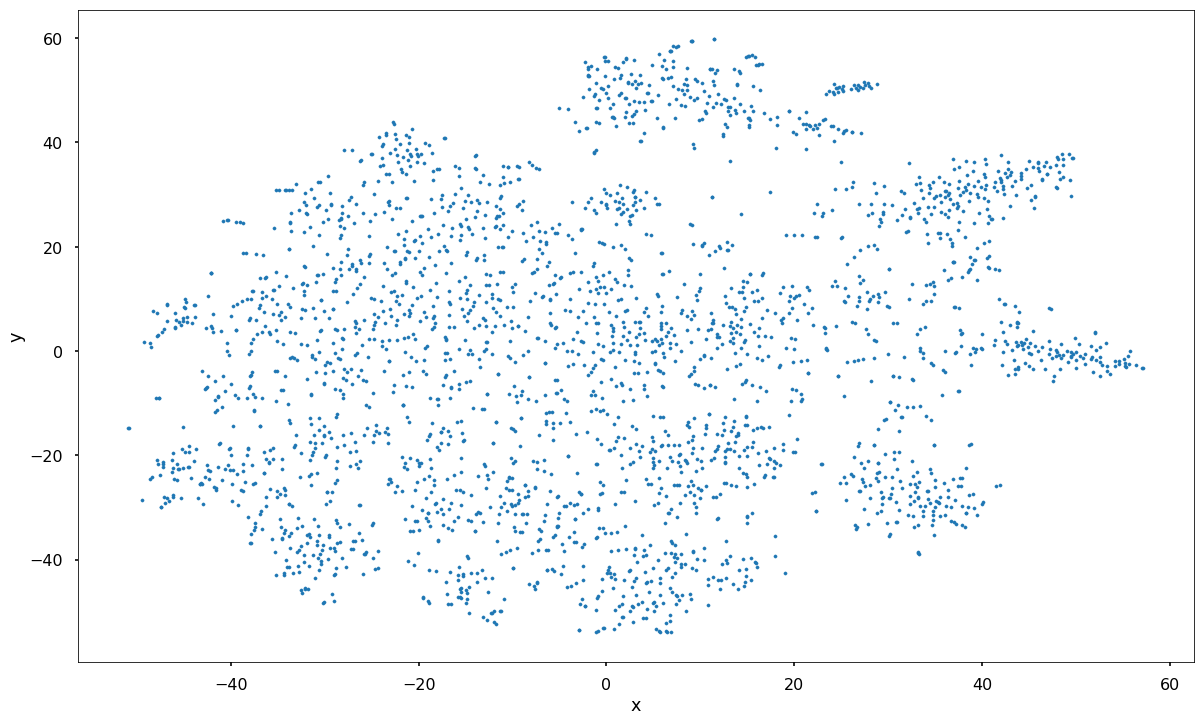

In [175]:
#plot the word vectors
points.plot.scatter("x","y", s=10, figsize=(20,12))

Shown below is a zoomed in region of the scatter plot. Similar items are located near each other.  For example, white rice is near long grain rice, beansoupmix is near driedbabylimabeans.

In [176]:
#zoom in

def plot_region(x_bounds,y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
    

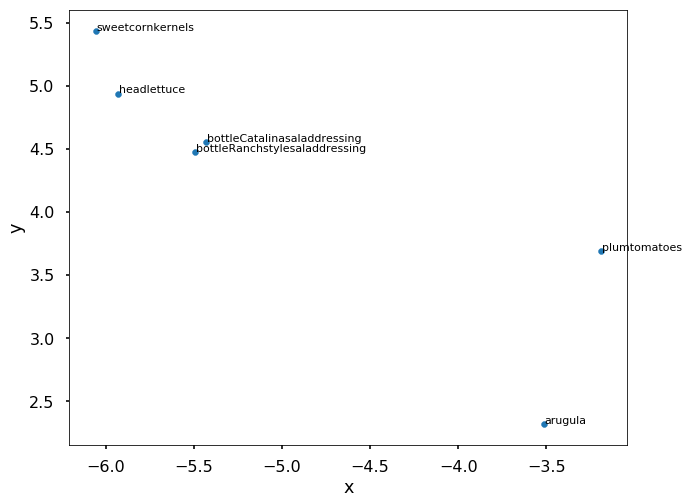

In [195]:
plot_region(x_bounds=(-7.1,-2.8), y_bounds=(2.1,6.1))

### Finding items which are most similar to a given ingredient

##### Ingredients which are most similar to ground beef:

In [112]:

ingred_cat_model.wv.most_similar("groundbeef")

[('extraleangroundbeef', 0.7875096201896667),
 ('groundsausage', 0.7234644889831543),
 ('condensedtomatosoup', 0.7140675783157349),
 ('groundbeefchuck', 0.6994967460632324),
 ('stuffedmaindishes', 0.6985939741134644),
 ('dryzitipasta', 0.6852942705154419),
 ('groundround', 0.6849061846733093),
 ('meatloaf', 0.683943510055542),
 ('porksausage', 0.6809939742088318),
 ('extragroundbeef', 0.6803674697875977)]

##### Ingredients which are most similar to tomatoes:

In [113]:
ingred_cat_model.wv.most_similar("tomatoes")

[('Italianstyletomatoes', 0.7601093053817749),
 ('Anaheimpeppers', 0.7431427240371704),
 ('hotItaliansausage', 0.7398403882980347),
 ('cantomatoes', 0.7363952398300171),
 ('petitetomatoes', 0.7356711626052856),
 ('hotsalsa', 0.733088493347168),
 ('vegetarianbakedbeans', 0.7308377027511597),
 ('Italiansausagelinks', 0.72987961769104),
 ('burgerstylecrumbles', 0.7294920682907104),
 ('wholetomatoesjuice', 0.7261921763420105)]

In [114]:
ingred_cat_model.wv.most_similar("noodles")

[('wideeggnoodles', 0.8342437148094177),
 ('fatfreecondensedcreamofmushroomsoup', 0.8272289633750916),
 ('containercottagecheese', 0.823729395866394),
 ('bowtiepastafarfalle', 0.8221156597137451),
 ('pintsourcream', 0.8190723657608032),
 ('Orientalflavoredramennoodles', 0.8142992854118347),
 ('pastabyshape', 0.8125942945480347),
 ('beefonionsoupmix', 0.8102462291717529),
 ('containercurdcottagecheese', 0.7869770526885986),
 ('chunkypastasauce', 0.786331832408905)]

##### Ingredients which are most similar to almond milk:

In [115]:
ingred_cat_model.wv.most_similar("almondmilk")

[('flaxseeds', 0.9268785715103149),
 ('flaxseedmeal', 0.9236542582511902),
 ('scoopvanillaproteinpowder', 0.9210433959960938),
 ('hempseeds', 0.9207671880722046),
 ('almondbutter', 0.913506805896759),
 ('groundflaxseed', 0.9078475832939148),
 ('vanillaproteinpowder', 0.9049567580223083),
 ('flaxseed', 0.9044904708862305),
 ('chiaseeds', 0.9044469594955444),
 ('soymilk', 0.8981873989105225)]

##### Ingredients which are most similar to cabbage:

In [116]:
ingred_cat_model.wv.most_similar("cabbage")

[('headcabbage', 0.7938015460968018),
 ('bunchescollardgreens', 0.7496548295021057),
 ('headredcabbage', 0.7375465035438538),
 ('containerschickenbroth', 0.732628345489502),
 ('bambooshoots', 0.7145119309425354),
 ('chickensoupbase', 0.7068522572517395),
 ('carawayseeds', 0.7053797245025635),
 ('whitepotatoes', 0.7006685137748718),
 ('bakingpotato', 0.697655439376831),
 ('hamhock', 0.6905401945114136)]

##### Ingredients which are most similar to mushrooms:

In [117]:
ingred_cat_model.wv.most_similar("mushrooms")

[('sirlointips', 0.7090818881988525),
 ('Burgundywine', 0.6916518211364746),
 ('buttonmushrooms', 0.672767162322998),
 ('farfallebowtiepasta', 0.6725322008132935),
 ('bulkmildItaliansausage', 0.6648626327514648),
 ('criminimushrooms', 0.6576216220855713),
 ('Italiansausage', 0.6535452604293823),
 ('Frenchbaguette', 0.648229718208313),
 ('loafFrenchbread', 0.6481917500495911),
 ('zitipasta', 0.648087203502655)]

##### Ingredients which are most similar to beef:

In [118]:
ingred_cat_model.wv.most_similar("beef")

[('steaks', 0.8247066736221313),
 ('sirloinsteak', 0.7816285490989685),
 ('rib', 0.7665889859199524),
 ('eyesteak', 0.7591760754585266),
 ('filetmignon', 0.7522463798522949),
 ('cubesteaks', 0.7485196590423584),
 ('roundsteak', 0.7352834939956665),
 ('beefstroganoff', 0.7299438714981079),
 ('ribeyesteaks', 0.7166787981987),
 ('beefconsomme', 0.7082864046096802)]

##### Ingredients which are most similar to quinoa:

In [119]:
ingred_cat_model.wv.most_similar("quinoa")

[('Frenchgreenlentils', 0.8063772916793823),
 ('bulgur', 0.7981781959533691),
 ('greenlentils', 0.7962607145309448),
 ('sweetpeas', 0.7902728915214539),
 ('chilepepper', 0.7874459028244019),
 ('driedlentils', 0.7798192501068115),
 ('lentils', 0.7785259485244751),
 ('dryredlentils', 0.778211236000061),
 ('balsamicvinaigrettesaladdressing', 0.7744874954223633),
 ('cubevegetablebouillon', 0.7719285488128662)]

##### Ingredients which are most similar to cookies:

In [196]:
ingred_cat_model.wv.most_similar("cookies")

[('desserts', 0.977564811706543),
 ('semisweetchocolatechips', 0.9615703225135803),
 ('brownies', 0.9521342515945435),
 ('chocolatebrownies', 0.9463282823562622),
 ('dropcookies', 0.9270548820495605),
 ('nutdesserts', 0.9259792566299438),
 ('fruitdesserts', 0.9257577657699585),
 ('oatmealcookies', 0.9245960712432861),
 ('bakecookies', 0.9174177646636963),
 ('no', 0.912896990776062)]

### Showing analogies: ingredient A is to ingredient B as ? is to ingredient C

We are using cosine similarity to calculate the similarities among ingredients.

In [197]:
# using cosine similarity 
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = ingred_cat_model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    
    print(start1, "is related to", end1, "as", start2, "is related to", end2)
    return start2
    

We will pass in three parameters to the nearest_similarity_cosmul function: start1: ingredient A, end1: ingredient B, end2: ingredient C

In [198]:
nearest_similarity_cosmul("rice","groundbeef","chicken")

rice is related to groundbeef as skinlesschickenbreast is related to chicken


'skinlesschickenbreast'

In [199]:
nearest_similarity_cosmul("cabbage","rice","pasta")

cabbage is related to rice as ChickenPasta is related to pasta


'ChickenPasta'

In [200]:
nearest_similarity_cosmul("flour","beef","chicken")

flour is related to beef as margarinebutter is related to chicken


'margarinebutter'

In [201]:
nearest_similarity_cosmul("chickenstock","turkey","pork")

chickenstock is related to turkey as apples is related to pork


'apples'

In [202]:
nearest_similarity_cosmul("onion","pork", "mushrooms")

onion is related to pork as Italianstyletomatoes is related to mushrooms


'Italianstyletomatoes'

The analogies tested above are reasonable. 

#### Looking up recipes that contain multiple ingredients

One of the objectives of this project is to be able to quickly find recipes given ingredients that the home cook has on hand.  We will now write a function that returns recipes which contain multiple ingredients and sort them by average rating.

In [203]:
# Lookup recipes that contain ingredients
def find_recipes_with_ingredient(ingred,ingred2):
    match = dataR[dataR['ingred_cat'].str.contains(ingred)] 
    match2 = match[match['ingred_cat'].str.contains(ingred2)]
    match3 = match2.sort_values('rating', ascending=False)
    
    return match3

##### Recipes which contain both spinach and chicken, sorted by highest rating

In [204]:

find_recipes_with_ingredient('spinach','chickenthighs').head(5)


,level_0,index,title,category,categories,ingred,ingred_cat,rating,review_cnt,reviews_text
2525,2525,2525,"Chicken, Spinach, and Potato Soup",Chicken Soup,"['Soups, Stews and Chili', 'Soup', 'Chicken So...","skinless,bonelesschickenthighs,chickenstock,wa...",skinless bonelesschickenthighs chickenstock wa...,4.50,56,"""this was the greatest recipe for soup i have ..."
8187,8187,8187,Scrumptious Chicken Vegetable Stew,Chicken,"['Soups, Stews and Chili', 'Stews', 'Chicken']","boneless,skinlesschickenthighsbreasts,carrots,...",boneless skinlesschickenthighsbreasts carrots ...,4.47,28,'this is an excellent healthy stew that reall...


##### Recipes which contain both white chocolate chips and eggs, sorted by highest rating

In [205]:
find_recipes_with_ingredient('whitechocolatechips','eggs').head(5)

,level_0,index,title,category,categories,ingred,ingred_cat,rating,review_cnt,reviews_text
10334,10334,10334,White Chocolate Raspberry Cheesecake,Raspberry Desserts,"['Desserts', 'Fruit Desserts', 'Raspberry Dess...","chocolatecookiecrumbs,whitesugar,butter,melted...",chocolatecookiecrumbs whitesugar butter melted...,4.83,2263,"""i made 2 cakes. the 1st one wasn't very appea..."
10330,10330,10330,White Chocolate Chip Oatmeal Cookies,Oatmeal Cookies,"['Desserts', 'Cookies', 'Oatmeal Cookies']","butter,lightbrownsugar,whitesugar,eggs,vanilla...",butter lightbrownsugar whitesugar eggs vanilla...,4.67,609,'this recipe was one i have used over and over...
9161,9161,9161,Stephen's Chocolate Chip Cookies,American Cookies,"['Desserts', 'Cookies', 'International Cookies...","butter,brownsugar,whitesugar,eggs,vanillaextra...",butter brownsugar whitesugar eggs vanillaextra...,4.61,283,'excellent! all my friends ask for this recip...
10328,10328,10328,White Chip Chocolate Cookies,Drop Cookies,"['Desserts', 'Cookies', 'Drop Cookies']","butter,whitesugar,eggs,vanillaextract,allpurpo...",butter whitesugar eggs vanillaextract allpurpo...,4.61,466,"""well i could tell from the start that this r..."
10335,10335,10335,"White Chocolate, Chocolate Cookies",Drop Cookies,"['Desserts', 'Cookies', 'Drop Cookies']","unsaltedbutter,whitesugar,packedbrownsugar,egg...",unsaltedbutter whitesugar packedbrownsugar egg...,4.52,499,"""in my circle of friends it's a well known fac..."


##### Recipes which contain both white chocolate chips and eggs, sorted by highest rating

In [206]:
find_recipes_with_ingredient('tomatoes','groundbeef').head(5)

,level_0,index,title,category,categories,ingred,ingred_cat,rating,review_cnt,reviews_text
6631,6631,6631,One-Pot Taco Chili,Knorr&#174;,"['Trusted Brands: Recipes and Tips', 'Knorr&#1...","onion,groundbeef,pintobeans,tomatoes,un,beefbr...",onion groundbeef pintobeans tomatoes un beefbr...,5.00,3,'delicious! fast and very tasty! would be grea...
9553,9553,9553,Taco Chili from Publix®,Publix Aprons,"['Trusted Brands: Recipes and Tips', 'Publix A...","groundbeef,tomatoesgreenchiles,un,chilibeansin...",groundbeef tomatoesgreenchiles un chilibeansin...,5.00,2,'followed the recipe and we all really enjoyed...
6205,6205,6205,Micah's 4 1/2-Alarm Chili,Pork Chili,"['Soups, Stews and Chili', 'Chili', 'Pork Chili']","groundbeef,more,onion,more,bacon,kidneybeans,u...",groundbeef more onion more bacon kidneybeans u...,5.00,3,'i just made this tonight and everyone loved i...
5460,5460,5460,Karen's Chili Con Carne Soup,Beef Chili,"['Soups, Stews and Chili', 'Chili', 'Beef Chili']","vegetableoil,onions,clovegarlic,groundbeef,who...",vegetableoil onions clovegarlic groundbeef who...,5.00,0,
3372,3372,3372,DB's Seven Pepper Chili,Beef Chili,"['Soups, Stews and Chili', 'Chili', 'Beef Chili']","beeftip,bottlebarbequesauce,onion,greenbellpep...",beeftip bottlebarbequesauce onion greenbellpep...,4.95,15,'i found this recipe easy to follow except tha...


##### Recipes which contain both white pork and beans, sorted by highest rating

In [207]:
find_recipes_with_ingredient('pork','beans').head(5)

,level_0,index,title,category,categories,ingred,ingred_cat,rating,review_cnt,reviews_text
3914,3914,3914,Feijoada de Domingo (Sunday Bean Stew),Pork,"['Soups, Stews and Chili', 'Stews', 'Pork']","quartswater,driedblackbeans,bayleaves,saltpepp...",quartswater driedblackbeans bayleaves saltpepp...,5.0,1,'great recipe!'
4828,4828,4828,Hawg Wild Black-Eyed Peas,Beans and Peas,"['Side Dish', 'Beans and Peas']","driedblackeyedpeas,smokedporkjowl,into,tassoha...",driedblackeyedpeas smokedporkjowl into tassoha...,5.0,2,'fantastic! easy to make and delicious!' 'gr...
2087,2087,2087,Cattleman's Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","coldwater,driedpintobeans,butter,bulkporksausa...",coldwater driedpintobeans butter bulkporksausa...,5.0,1,"""this recipe is great over white rice! i didn'..."
1025,1025,1025,Bean-Hole Beans,Baked Beans,"['Side Dish', 'Beans and Peas', 'Baked Beans']","driedgreatNorthernbeans,saltpork,onions,molass...",driedgreatNorthernbeans saltpork onions molass...,5.0,2,'never having beans made this way it was an ex...
5989,5989,5989,Marko's Smokin' Barbeque Sauce Pork Salad,Green Salads,"['Salad', 'Green Salads']","lettuce,blackbeans,Mexicanstylecorn,smokedpork...",lettuce blackbeans Mexicanstylecorn smokedpork...,5.0,1,'perfect as written really. just make sure you...


## Reflection


Several approaches were attempted in order to develop a recommender system to make it easier for home cooks to find recipes. A very important part of the process was cleaning up the data and making it as understandable as possible for the algorithms to process.  For example, handling ingredients that consist of multiple words, such as "olive oil" and combining them into one term: "oliveoil". The machine learning algorithms think in the language of math and so the data had to be easily translatable into math.<br>

The Word2Vec model gave impressive results when it came to predicting ingredients which are similar to a given ingredient. For example: given "beef", the ingredients which were predicted by the model include:<br>
steaks, 83.94%<br>
sirloinsteak, 80.14%<br>
rib, 78.37%<br>
eyesteak, 77.85%<br>
filetmignon, 74.98%<br>
ribeyesteaks, 73.85%<br>
cubesteaks', 72.63%<br>
beefstroganoff, 72.54%<br>
flatironsteak, 71.61%<br>
cornedbeef, 71.09%<br>

A good use case for this would be if a user clicks on a recipe and the main ingredient in that recipe is "beef", then our algorithm could see the similar ingredients listed above and present recipes that contain those ingredients.  Word2Vec figured out that "steak" is similar to "beef". Our frontend app would now be able to present useful and relevant recipes for beef, even if none of the words in the recipe contains "beef".

Using TF-IDF, we also are able to find recipes which are similar to a given recipe. So if a user has recently selected a recipe like "Easy Lasagna I", then our recommender system will find recipes that are similar to lasgna but don't necessarily contain the word "lasagna", for example: "Meat Filled Manicotti", "Baked Spaghetti Casserole", "Manicotti" and "Italian Veggie Rolls". 

Given that there are hundreds of thousands of recipes available online, it would be very useful to have a recommender system to help people choose. It would be an even better system if it can be personalized to each user. I would like to build a mobile app which tracks the recipes each user selects, the search terms they enter, and any recipe they save, so that the Recommender System can also make recommendationg based on collaborative filtering. With collaborative filtering, the system could show that people who liked the recipes that you like, also liked these other recipes and so there is a high probability that you may like them, too.  